## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
data = pd.read_csv('spam.csv',delimiter=',' ,encoding='latin-1')

In [3]:
data.head()
data.drop(['Unnamed: 2',	'Unnamed: 3'	,'Unnamed: 4'],axis=1, inplace = True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# splitting into x and y
X = data['v2']
y = data['v1']

## Text Pre-processing

In [5]:
encoder = LabelEncoder()  # encoding the labels spam, ham into 0 and 1
y = encoder.fit_transform(y)

In [6]:
y.shape

(5572,)

In [7]:
y = y.reshape(-1,1)  # converting from 1D numpy array to 2D array

In [8]:
y.shape

(5572, 1)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.15)

# Tokenization

In [12]:
max_words = 1000   # length of vocabulary
max_len = 150       # length of padded vectors
#both of the above are hyperparameters

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [13]:
sequences_matrix[:5]   #sparse matrix of word vectors

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  46, 522, 436,   2, 523, 436,  28, 309, 111,  46,
         67,   2, 163, 249, 111,  77, 250],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

In [14]:
sequences_matrix.shape  # from the shape we can see that each word is of length 150 

(4736, 150)

In [26]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

# Building The Neural Network

In [27]:
def LSTM_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)  #vocab, vector space ;output of the Embedding layer is a 2D vector # 50 lstm units
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer) # fully connected 1
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [28]:
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

# Model Training and Testing

#### Training the model

In [31]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_data=(test_sequences_matrix,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
37/37 [==============================] - 7s 192ms/step - loss: 0.1055 - accuracy: 0.9711 - val_loss: 0.0617 - val_accuracy: 0.9785
Epoch 2/10
37/37 [==============================] - 7s 179ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 0.0483 - val_accuracy: 0.9880
Epoch 3/10
37/37 [==============================] - 7s 179ms/step - loss: 0.0264 - accuracy: 0.9922 - val_loss: 0.0463 - val_accuracy: 0.9892
Epoch 4/10
37/37 [==============================] - 7s 178ms/step - loss: 0.0170 - accuracy: 0.9962 - val_loss: 0.0499 - val_accuracy: 0.9880


In [33]:
history.history

{'accuracy': [0.9710726141929626,
  0.9879645109176636,
  0.9921875,
  0.9961993098258972],
 'loss': [0.10553456097841263,
  0.04116370901465416,
  0.02642694301903248,
  0.016971975564956665],
 'val_accuracy': [0.9784688949584961,
  0.9880383014678955,
  0.989234447479248,
  0.9880383014678955],
 'val_loss': [0.06171702593564987,
  0.048293836414813995,
  0.046306248754262924,
  0.04987020790576935]}

## Plotting Accuracy

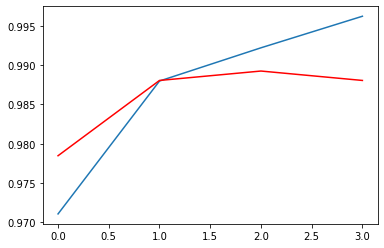

In [38]:
plt.plot(range(4),history.history['accuracy'])
plt.plot(range(4),history.history['val_accuracy'],color='r')

## Plotting Losses

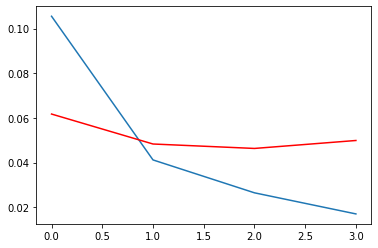

In [43]:
plt.plot(range(4),history.history['loss'])
plt.plot(range(4),history.history['val_loss'],color='r')

In [42]:
text=["You are awarded a Nikon Digital Camera. Call now"]
sentence = tok.texts_to_sequences(text)
text_matrix = sequence.pad_sequences(sentence,maxlen=max_len)
model.predict(text_matrix)

array([[0.9952125]], dtype=float32)

## The End